# 미니 프로젝트 : 나랑 닮은 꼴 연예인 찾기

상대방을 보고 __연예인 닮았다__는 칭찬을 하는 것을 흔히 볼 수 있다.

또한, 종종 연예인을 닮은 사람이 등장해 많은 화제 거리가 되고는 한다.

이쯤에서 드는 생각이 있다.

_과연 나랑 닮은 연예인은 없을까?_

__Face Embedding__ 을 이용해 닮은 연예인을 찾고 나도 간헐적 연예인이 될 수 있을까 확인해보자.

![image](https://user-images.githubusercontent.com/84179578/127106787-0c88d2f9-1522-4696-baf5-59a58a9bced2.png)

핵심 내용
- 얼굴 영역만 인식해서 추출
- 고차원의 이미지 벡터를 저차원의 벡터로 변환하면서 필요한 정보는 보존하는 임베딩(Embedding)
- 얼굴 임베딩 벡터 사이의 거리가 두 얼굴이 얼마나 닮았나를 반영

# 0. 필요한 모듈 불러오기

In [1]:
import os
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.image as img
import face_recognition
import os
from PIL import Image

# 1. 이미지 수집

나랑 닮은 연예인을 찾으려면 본인 사진과 연예인의 사진을 수집해야한다.  

먼저 내 사진들을 사진첩에서 다수 가져와 `EP05_data_2/leejaejun` 디렉토리에 저장하였다.

사진을 가져와서 `matplotlib` 로 확인해보자.

my_file_list: ['이재준1.jpg', '이재준2.jpg', '이재준4.jpg', '이재준3.jpg']


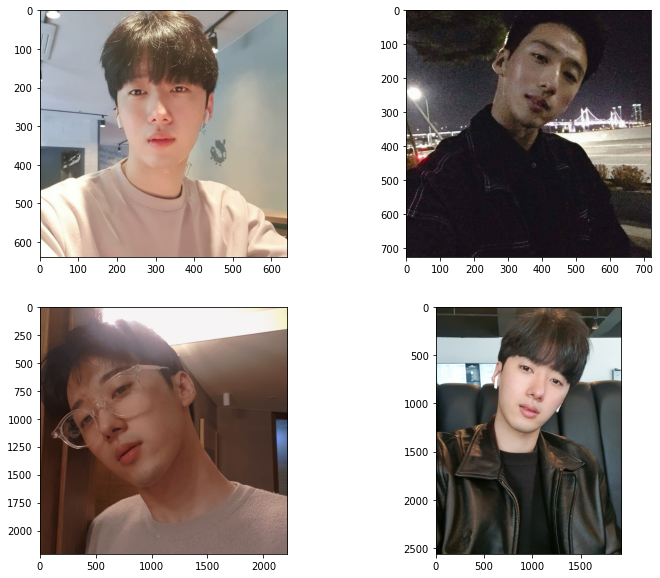

In [2]:
import os
import numpy as np


my_dir_path = 'EP05_data_2/leejaejun'
my_file_list = os.listdir(my_dir_path)

print ("my_file_list: {}".format(my_file_list))

import matplotlib.pyplot as plt
import matplotlib.image as img

#Set figsize here
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,10))

# flatten axes for easy iterating
for i, ax in enumerate(axes.flatten()):
    image = img.imread(my_dir_path+'/'+my_file_list[i])
    ax.imshow(image)
plt.show()

fig.tight_layout()

다음으로 다양한 연예인 사진을 불러와야한다. 연예인 사진을 다양하게 많이 모을 수록 나와 더 닮은 연예인을 찾을 가능성이 높아진다.  

다양한 연예인 사진을 수집하여 `EP05_data_2/celebrity` 디렉토리에 저장하였다.

In [3]:
cel_dir_path = 'EP05_data_2/celebrity'

## 2. 얼굴 영역 자르기  

다음으로 얼굴 임베딩을 하기전에 필요한 부분인 얼굴 영역만 잘라내자.

이후 다양한 시각화를 위해 자른 이미지는 `PIL.Image.fromarray` 를 통해서 PIL Image 로 변환하여 `EP05_data2/cropped_img` 디렉토리에 저장하겠다.

In [4]:
def get_cropped_face(image_file):
    image = face_recognition.load_image_file(image_file)
    face_locations = face_recognition.face_locations(image)

    a, b, c, d = face_locations[0]
    cropped_face = image[a:c,d:b,:]
    
    return cropped_face

def save_cropped_face(dir_path, path_to_save):    # PIL Image 로 변환하여 저장
    file_list = os.listdir(dir_path)
    for file in file_list:
        try:
            img_path = os.path.join(dir_path, file)
            face = get_cropped_face(img_path)
            pillow_image = Image.fromarray(face)
            pillow_image.save(path_to_save + os.path.basename(file))
        except:
            print(f'{file} 이미지의 얼굴 영역을 찾을 수 없습니다.')
            pass

In [5]:
path_to_save = 'EP05_data_2/cropped_img/'

save_cropped_face(my_dir_path, path_to_save)

`path_to_save` 디렉토리에 얼굴이 잘린 이미지들이 잘 저장 되었는지 확인해보자.

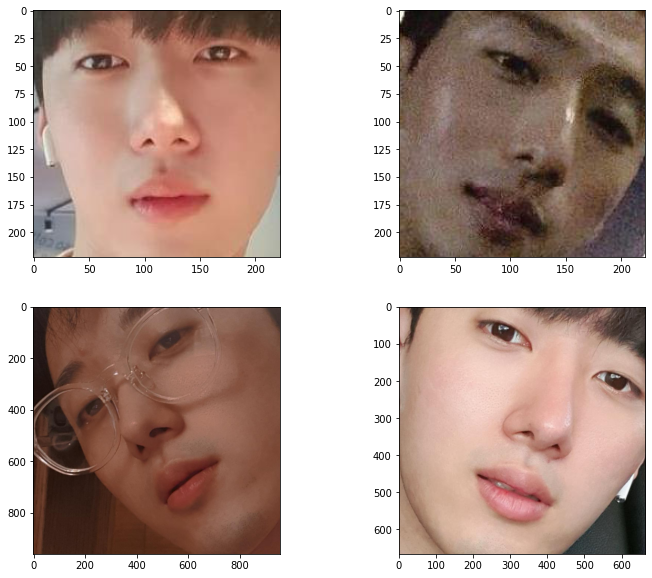

In [6]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,10))

# flatten axes for easy iterating
for i, ax in enumerate(axes.flatten()):
    image = img.imread(path_to_save+'/'+my_file_list[i])
    ax.imshow(image)
plt.show()

fig.tight_layout()

In [7]:
save_cropped_face(cel_dir_path, path_to_save)

산들.jpg 이미지의 얼굴 영역을 찾을 수 없습니다.
.ipynb_checkpoints 이미지의 얼굴 영역을 찾을 수 없습니다.


연예인 사진들도 얼굴 영역을 찾아서 자른 사진을 `EP05_data2/cropped_img` 디렉토리에 저장하였다.  

이때, 산들.jpeg 의 사진은 얼굴 영역을 찾을 수 없어 `pass` 했다.

## 3. 얼굴 영역 임베딩 추출

이제 얼굴 영역만 잘린 이미지들을 `face_recognition` 을 사용해서 임베딩을 추출해보자.

이 과정을 위해 다음과 같이 함수를 정의한다.
- `get_face_embedding()` : 얼굴 영역을 가지고 얼굴 임베딩 벡터를 구하는 함수
- `get_face_embedding_dict()` : 디렉토리 안에 있는 모든 이미지의 임베딩 딕셔너리를 구하는 함수


In [8]:
def get_face_embedding(face):
    return face_recognition.face_encodings(face)

In [9]:
def get_face_embedding_dict(dir_path):
    file_list = os.listdir(dir_path)
    embedding_dict = {}
    
    for file in file_list:
        image_path = os.path.join(dir_path, file)
        try:
            face = get_cropped_face(image_path)
            embedding = get_face_embedding(face)
            if len(embedding) > 0:
                embedding_dict[os.path.splitext(file)[0]] = embedding[0]
        except:              
            pass                 # 얼굴 영역을 못찾을 경우 pass
    return embedding_dict

In [10]:
my_embedding_dict = get_face_embedding_dict(my_dir_path)    # 내 얼굴 임베딩 딕셔너리

cel_embedding_dict = get_face_embedding_dict(cel_dir_path)  # 연예인 얼굴 임베딩 딕셔너리

내 얼굴 임베딩 벡터와 연예인 얼굴 임베딩 벡터를 총합한 딕셔너리를 만들자.

In [11]:
def merge_dicts(a,b):
    
    c = a.copy()  # a 변수를 c에 copy 한 후,
    c.update(b)   # c를 update하여 반환

    return c

In [12]:
embedding_dict = merge_dicts(my_embedding_dict, cel_embedding_dict)

## 4. 임베딩 벡터 간 거리 구하기

얼굴이 얼마나 닮은지 판단하기 위해 임베딩 벡터 간의 거리를 구해서 비교해야한다.

이 과정을 위해 다음과 같이 함수를 정의한다.
- `get_distance(name1, name2)` : 인자로 파일명의 사람 이름 2개를 받아서, 두 사람의 얼굴 임베딩 사이의 거리(L2 distance)를 구하는 함수
- `get_sort_key_func()` : name1과 name2의 거리를 비교하는 함수. 이때, name1은 미리 지정하고, name2는 호출시에 인자로 받도록 함
- `get_nearest_face()` : 입력받은 임의의 이름에 대해 다른 이미지의 임베딩 거리를 정렬해서 출력하는 함수

In [13]:
def get_distance(name1, name2):
    return np.linalg.norm(embedding_dict[name1]-embedding_dict[name2], ord=2)

In [14]:
def get_sort_key_func(name1):
    def get_distance_from_name1(name2):
        return get_distance(name1, name2)
    return get_distance_from_name1

In [15]:
def get_nearest_face(name, top=5):
    sort_key_func = get_sort_key_func(name)
    sorted_faces = sorted(embedding_dict.items(), key=lambda x:sort_key_func(x[0]))
    
    rank=1
    i=0
    while rank < top+1:
        if '이재준' in sorted_faces[i][0]:   # 나의 사진은 건너뜀
            i += 1
            continue
        if sorted_faces[i]:
            print('순위 {} : 이름({}), 거리({})'.format(rank , sorted_faces[i][0], sort_key_func(sorted_faces[i][0])))
            rank += 1
            i += 1

닮은 연예인을 찾기 전에 내 얼굴 임베딩 벡터 간의 거리를 확인해보겠다.

In [16]:
def get_my_nearest_face(name, top=3):
    sort_key_func = get_sort_key_func(name)
    sorted_faces = sorted(embedding_dict.items(), key=lambda x:sort_key_func(x[0]))
    
    rank=1
    i=1    # 기준 이미지는 거리가 0 이므로 제외
    while rank < top+1:

        if '이재준' in sorted_faces[i][0]:   # 내 얼굴 사진만을 선택
            print('순위 {} : 이름({}), 거리({})'.format(rank , sorted_faces[i][0], sort_key_func(sorted_faces[i][0])))
            rank += 1
            i += 1
        else:
            i += 1

In [17]:
get_my_nearest_face('이재준1')

순위 1 : 이름(이재준3), 거리(0.3339132491160129)
순위 2 : 이름(이재준4), 거리(0.36098045857863625)
순위 3 : 이름(이재준2), 거리(0.4093253073495425)


사진마다 다르지만 전체적으로 작은 값들이 나오는 것을 알 수 있다.  

`이재준1` 이미지를 기준으로 한 내 얼굴 임베딩 벡터간의 거리의 평균은 0.36807 이다.

이제 연예인 얼굴 임베딩 벡터와의 거리를 비교해보자.  

거리가 가장 가까운, 즉 가장 닮은 연예인사진 5개를 정렬하였다.

In [18]:
get_nearest_face('이재준1')

순위 1 : 이름(목진화), 거리(0.37566977532261653)
순위 2 : 이름(류준열), 거리(0.3923491741732033)
순위 3 : 이름(정국), 거리(0.3932080695835759)
순위 4 : 이름(첸), 거리(0.39362128262749274)
순위 5 : 이름(제이홉), 거리(0.3998418887241481)


In [19]:
get_nearest_face('이재준2')

순위 1 : 이름(목진화), 거리(0.4198199997346537)
순위 2 : 이름(박명수), 거리(0.42708001106841303)
순위 3 : 이름(박해일), 거리(0.42909284439700296)
순위 4 : 이름(박건우), 거리(0.4306557492359461)
순위 5 : 이름(태양), 거리(0.45126135509530607)


In [20]:
get_nearest_face('이재준3')

순위 1 : 이름(아이린), 거리(0.39330044994188695)
순위 2 : 이름(태연), 거리(0.4033190163504035)
순위 3 : 이름(장원영), 거리(0.40475336203512774)
순위 4 : 이름(리아), 거리(0.40650395047566545)
순위 5 : 이름(목진화), 거리(0.40658214044688124)


In [21]:
get_nearest_face('이재준4')

순위 1 : 이름(공효진), 거리(0.3946469612535417)
순위 2 : 이름(유노윤호), 거리(0.42188628900898867)
순위 3 : 이름(케이), 거리(0.4505890352550536)
순위 4 : 이름(제이홉), 거리(0.4567206513560779)
순위 5 : 이름(박건우), 거리(0.45786786539575436)


사진마다 가장 닮은 연예인 5명이 나온다.

## 5. 시각화

그럼 이제 내가 위에 나온 연예인 분들과 어떻게 닮았는지 시각화를 해보아야 조금이나마 이해가 될 것이다.  

OpenCV 를 이용하여 내 사진과 닮은 꼴의 연예인 사진을 천천히 비교해보자.

In [59]:
import cv2

def compare_nearest_face(name, top=5):
    sort_key_func = get_sort_key_func(name)
    sorted_faces = sorted(embedding_dict.items(), key=lambda x:sort_key_func(x[0]))
    
    rank=1
    i=0
    
    while rank < top+1:
        if '이재준' in sorted_faces[i][0]:   # 나의 사진은 건너뜀
            i += 1
            continue
        if sorted_faces[i]:
            print('순위 {} : 이름({}), 거리({})'.format(rank , sorted_faces[i][0], sort_key_func(sorted_faces[i][0])))
            

            img = cv2.imread(path_to_save + name + '.jpg')
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            fig, axes = plt.subplots(1, 5, figsize=(10, 10))
            print(sorted_faces[i][0])
            print(i)
            img_near = cv2.imread(path_to_save + sorted_faces[i][0]+'.jpg')
            img_near = cv2.cvtColor(img_near, cv2.COLOR_BGR2RGB)
            
            a=0
            idx=0
            while idx < 5:

                width = img_near.shape[1]
                height = img_near.shape[0]
                img = cv2.resize(img, (width, height))

                # img1 사진은 점점 투명해지고 img2 사진은 점점 불투명해짐
                b = 1.0 - a
                dst1 = cv2.addWeighted(img_near, a, img, b, 0)
                axes[idx].imshow(dst1)
                axes[idx].axis('off')
                a += 0.25
                idx += 1
            
            rank += 1
            i += 1

닮은 연예인 얼굴과 거리가 비교적 가까운 `이재준1` 의 이미지의 결과를 시각화 해보자.

순위 1 : 이름(목진화), 거리(0.37566977532261653)
목진화
3
순위 2 : 이름(류준열), 거리(0.3923491741732033)
류준열
4
순위 3 : 이름(정국), 거리(0.3932080695835759)
정국
5
순위 4 : 이름(첸), 거리(0.39362128262749274)
첸
6
순위 5 : 이름(제이홉), 거리(0.3998418887241481)
제이홉
7


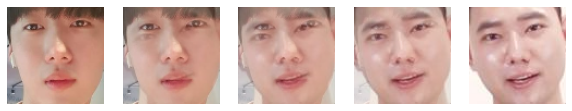

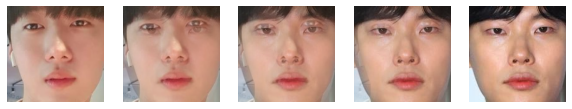

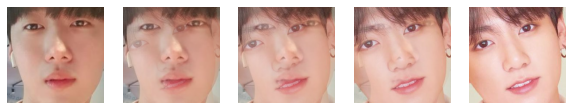

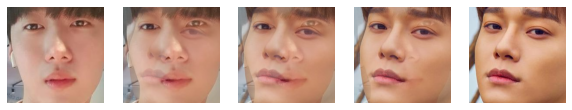

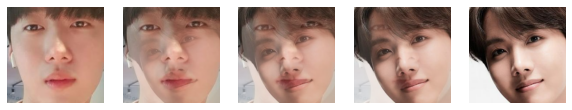

In [60]:
compare_nearest_face('이재준1')

이번에는 닮은 연예인이 여자 연예인이 많이 나온 `이재준3` 의 이미지를 시각화 해보자.

순위 1 : 이름(아이린), 거리(0.39330044994188695)
아이린
2
순위 2 : 이름(태연), 거리(0.4033190163504035)
태연
3
순위 3 : 이름(장원영), 거리(0.40475336203512774)
장원영
4
순위 4 : 이름(리아), 거리(0.40650395047566545)
리아
5
순위 5 : 이름(목진화), 거리(0.40658214044688124)
목진화
6


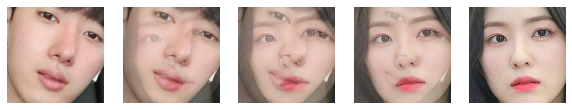

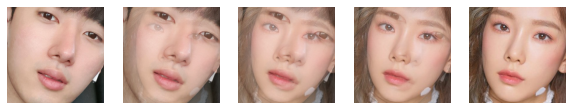

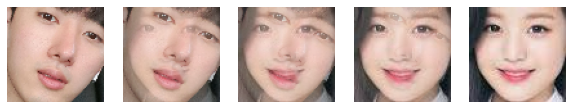

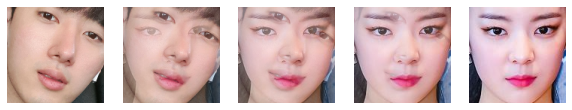

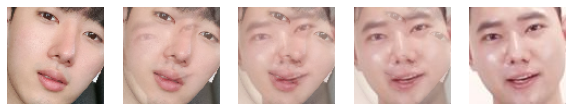

In [64]:
compare_nearest_face('이재준3')

# 프로젝트 정리

이번 프로젝트를 통해 이미지 간의 유사도를 알아내는 방법에 대해 공부하고 실행해보았다. 그 과정에서 얻은 정보,경험들에 대해 간략히 정리하겠다.  

- __1. 이미지 데이터 수집__
  -  다양한 이미지들을 수집해야 특정 이미지와의 유사도를 다양하게 얻을 수 있다. 즉, 많은 연예인 사진을 수집 할수록 나와 닮은 이미지를 찾을 확률이 높아진다.
  - 또한, 이미지 데이터 수집 과정에서 얼굴이 가려지거나, 이미지가 많이 손상되어있을 때 등의 환경에서는 얼굴 영역을 찾지못하거나, 얼굴 임베딩이 불가한 상황이 발생하였다. 이를 통해 데이터 수집 과정에서도 양질의 데이터를 수집하는게 중요하다는 것을 실감했다.  
  

- __2. 데이터 전처리__
  - 다양한 이미지 데이터를 불러와서 쉽게 작업하기위해 같은 확장자(.jpg)로 교체하였다.
  - 예외 구문을 통해 얼굴영역 찾기나 얼굴 임베딩이 불가한 이미지는 제외시켰다.

  
  

- __3.임베딩 벡터 거리__
  - 내 사진 간의 임베딩 벡터 거리는 평균 0.37 정도가 나왔다. 이 수치는 같은 사람이 찍은 사진 치고는 큰 벡터 거리 값이 나왔다.(가장 닮은 연예인 임베딩 벡터 거리가 3.9 임을 고려)
  - 그 이유는 내 사진이라도 이미지의 밝기, 이미지의 각도, 안경 등의 악세사리 착용 여부 등이 있을 것이라고 예상한다.
  

    
- __4. 닮은 연예인__
  - 내 사진을 바탕으로 여러 닮은 연예인 사진을 찾아보았다. 다양한 사람이 나왔지만 그 결과가 이해가 납득이 가는 사진도 있고, 이해 가지 않는 사진도 있었다.
 
 

- __5. 시각화__
  - 닮은 꼴로 나온 이유가 모호한 상황에서, 좀 더 직관적으로 닮은 꼴을 확인하기 위하여 닮은 이미지를 겹쳐 5단계에 따라서 이미지의 가중치를 달리하여 적용하였다.
  - 그 결과, 거리라는 숫자값으로 닮은 꼴을 판단하는 것 보다 훨씬 직관적으로 닮은 꼴을 확인 할 수 있었다.
 